# Importing dependencies 

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df = pd.read_csv('data_science_job.csv')

# Introductory EDA

In [2]:
# Checking the shape of the dataframe
df.shape

(19158, 13)

In [3]:
# Checking any 5 random rows
df.sample(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
16916,18650,city_21,0.624,Male,Has relevent experience,no_enrollment,Graduate,STEM,5.0,5000-9999,Pvt Ltd,22.0,1.0
10292,31088,city_21,0.624,Male,No relevent experience,no_enrollment,Graduate,STEM,1.0,<10,Early Stage Startup,7.0,0.0
17828,23630,city_75,0.939,Male,No relevent experience,no_enrollment,High School,NaN,0.0,NaN,NaN,11.0,0.0
3165,27705,city_114,0.926,NaN,Has relevent experience,no_enrollment,Masters,STEM,20.0,10000+,Pvt Ltd,57.0,0.0
11725,28376,city_65,0.802,Female,Has relevent experience,no_enrollment,Masters,STEM,12.0,NaN,NaN,88.0,0.0


In [4]:
# Checking data type of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


In [5]:
df[['target','training_hours','experience','city_development_index']] = df[['target','training_hours','experience','city_development_index']].astype(np.float32)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float32
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float32
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float32
 12  target                  19158 non-null  float32
dtypes: float32(4), int64(1), object(8)
memory usage: 1.6+ MB


In [6]:
# Descriptive information about the data
df.describe()

,enrollee_id,city_development_index,experience,training_hours,target
count,19158.000000,18679.000000,19093.000000,18392.000000,19158.000000
mean,16875.358179,0.828951,9.928037,65.185791,0.249348
std,9616.292592,0.123334,6.505268,59.885624,0.432647
min,1.000000,0.448000,0.000000,1.000000,0.000000
25%,8554.250000,0.740000,4.000000,23.000000,0.000000
50%,16982.500000,0.903000,9.000000,47.000000,0.000000
75%,25169.750000,0.920000,16.000000,88.000000,0.000000
max,33380.000000,0.949000,20.000000,336.000000,1.000000


In [7]:
# Checking percentage of null values
df.isnull().mean()*100

enrollee_id                0.000000
city                       0.000000
city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
dtype: float64

In [8]:
# Checking duplicated values
df.duplicated().sum()

0

<AxesSubplot:ylabel='target'>

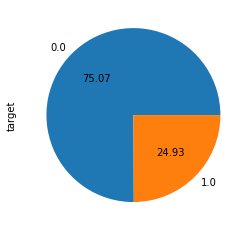

In [9]:
# Let's visualize proportion of classes in the target variable
df['target'].value_counts().plot(kind='pie',autopct='%.2f')

# Data preprocessing

In this step we will be handling the missing values,outliers and will also work on dealing with imbalanced data


In [10]:
df = df.drop(['enrollee_id','city','company_type','gender','major_discipline'],axis=1)
df.head(4)

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,training_hours,target
0,0.920,Has relevent experience,no_enrollment,Graduate,20.0,NaN,36.0,1.0
1,0.776,No relevent experience,no_enrollment,Graduate,15.0,50-99,47.0,0.0
2,0.624,No relevent experience,Full time course,Graduate,5.0,NaN,83.0,0.0
3,0.789,No relevent experience,NaN,Graduate,0.0,NaN,52.0,1.0


In [11]:
# First we will take a copy of some columns having null values to see if PCA should be applied or not
check_cca = [col for col in df.columns if df[col].isnull().mean()*100 <5 and df[col].isnull().mean()*100>0]
check = df[check_cca].copy()
check.head(5)

,city_development_index,enrolled_university,education_level,experience,training_hours
0,0.920,no_enrollment,Graduate,20.0,36.0
1,0.776,no_enrollment,Graduate,15.0,47.0
2,0.624,Full time course,Graduate,5.0,83.0
3,0.789,NaN,Graduate,0.0,52.0
4,0.767,no_enrollment,Masters,20.0,8.0


In [12]:
check['city_development_index'] = check['city_development_index'].dropna()
check['enrolled_university'] = check['enrolled_university'].dropna()
check['education_level'] = check['education_level'].dropna()
check['experience'] = check['experience'].dropna()
check['training_hours'] = check['training_hours'].dropna()

Now we will plot check that whether the distribution of data before and after PCA is comparable or not, if not then we will not use PCA

<AxesSubplot:>

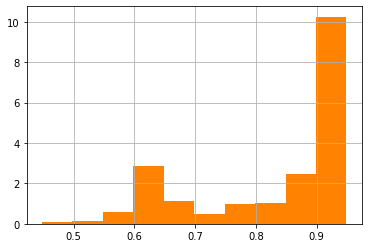

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

df['city_development_index'].hist(ax=ax, density=True, color='red')
check['city_development_index'].hist(ax=ax, color='orange', density=True, alpha=0.8)

<AxesSubplot:>

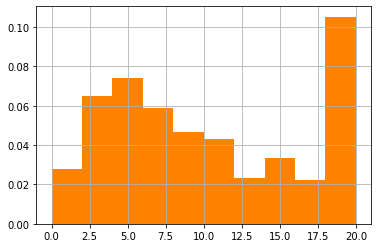

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

df['experience'].hist(ax=ax, density=True, color='red')
check['experience'].hist(ax=ax, color='orange', density=True, alpha=0.8)

<AxesSubplot:>

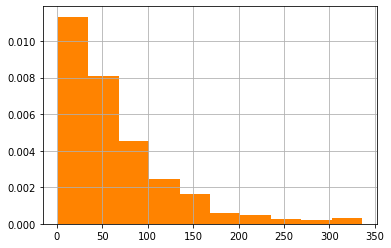

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

df['training_hours'].hist(ax=ax, density=True, color='red')
check['training_hours'].hist(ax=ax, color='orange', density=True, alpha=0.8)

For the categorical columns we will check the ratio of categories before and after applying PCA

In [16]:
comp_eu = pd.concat([df['enrolled_university'].value_counts() / len(df),
                    check['enrolled_university'].value_counts() / len(check)],axis=1)

comp_eu.columns = ['original','aftercca']
comp_eu

,original,aftercca
no_enrollment,0.721213,0.721213
Full time course,0.196106,0.196106
Part time course,0.062533,0.062533


In [17]:
edu_level = pd.concat([ df['education_level'].value_counts() / len(df),
                     check['education_level'].value_counts() / len(check) ],axis=1)

edu_level.columns = ['original','aftercca']
edu_level

,original,aftercca
Graduate,0.605387,0.605387
Masters,0.227633,0.227633
High School,0.105282,0.105282
Phd,0.021610,0.021610
Primary School,0.016077,0.016077


From the analysis we can safely remove the rows having missing values of columns in which the percentage of missing values is less than 5%

In [18]:
df.dropna(subset = ['city_development_index', 'enrolled_university', 'education_level',
                   'experience', 'training_hours'],inplace=True)

In [19]:
# Encoding company size

map_cs = {'<10':0,'10/49':1,'50-99':2,'100-500':3,'500-999':4,'1000-4999':5,'5000-9999':6,'10000+':7 }
df['company_size'] = df['company_size'].map(map_cs)

In [20]:
# Encoding enrolled_university column 

map_eu = {'Full time course':2 ,'Part time course':1, 'no_enrollment':0}
df['enrolled_university'] = df['enrolled_university'].map(map_eu)

In [21]:
# Encoding education_level column

map_el = {'Primary School':0, 'High School':1, 'Graduate':2,'Masters':3,'Phd':4}
df['education_level'] = df['education_level'].map(map_el)

In [22]:
# Encoding relevant experience column 

map_re = {'Has relevent experience':1,'No relevent experience':0}
df['relevent_experience'] = df['relevent_experience'].map(map_re)

In [23]:
# Now we will be using MICE for imputing the missing values in company_size variable
y = df['target']
X = df.drop(['target'],axis=1)
lr = LinearRegression()
imp = IterativeImputer(estimator=lr, verbose=2, max_iter=30, tol=1e-10, imputation_order='roman')

In [24]:
X = imp.fit_transform(X)

[IterativeImputer] Completing matrix with shape (17182, 7)
[IterativeImputer] Ending imputation round 1/30, elapsed time 0.06
[IterativeImputer] Change: 1.1481516213348897, scaled tolerance: 3.36e-08 
[IterativeImputer] Ending imputation round 2/30, elapsed time 0.11
[IterativeImputer] Change: 0.0, scaled tolerance: 3.36e-08 
[IterativeImputer] Early stopping criterion reached.


In [25]:
new_df = pd.DataFrame(X)
new_df.columns = ['city_development_index', 'relevent_experience', 'enrolled_university',
       'education_level', 'experience', 'company_size', 'training_hours']

In [26]:
target = df['target'].values
target = pd.Series(target)
new_df['Output'] = target

In [27]:
new_df.head(5)

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,training_hours,Output
0,0.920,1.0,0.0,2.0,20.0,3.537382,36.0,1.0
1,0.776,0.0,0.0,2.0,15.0,2.000000,47.0,0.0
2,0.624,0.0,2.0,2.0,5.0,3.097107,83.0,0.0
3,0.767,1.0,0.0,3.0,20.0,2.000000,8.0,0.0
4,0.764,1.0,1.0,2.0,11.0,3.093206,24.0,1.0


In [28]:
check = new_df['company_size'].astype(np.int32)
check

0        3
1        2
2        3
3        2
4        3
        ..
17177    3
17178    3
17179    2
17180    4
17181    2
Name: company_size, Length: 17182, dtype: int32

### Detecting outliers

- Left skewed : city_dev_index
- Right skewed : experience , training_hours
- Normal distribution

*Unfortunately, there are no outlier detection methods for categorical data [1]. However, you can use measures such as the mode to get an understanding of the distribution of the data. Additionally, you can use tools such as box and whisker plots to visualize the distribution of the data and identify any potential outliers.*


*If a boxplot is showing an IQR (interquartile range) that is the same length as the entire plot, it means that there is no variation in the data. This could be due to all the data points having the same value, or due to the data being heavily skewed in one direction. If you're seeing this, it could be worth investigating further to see what is causing the lack of variation.*

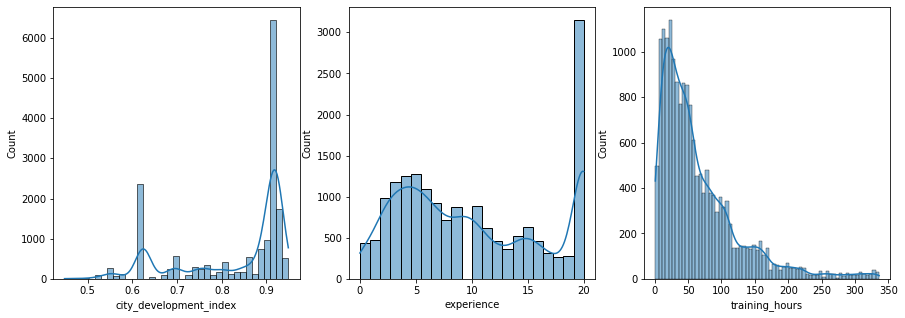

In [29]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first distplot on the first axes
sns.histplot(new_df['city_development_index'],kde=True, ax=ax[0])
sns.histplot(new_df['experience'],kde=True, ax=ax[1])
sns.histplot(new_df['training_hours'],kde=True, ax=ax[2])

# Show the plot
plt.show()

Since all the above 3 columns are skewed so we will use boxplot detect and visualize outliers

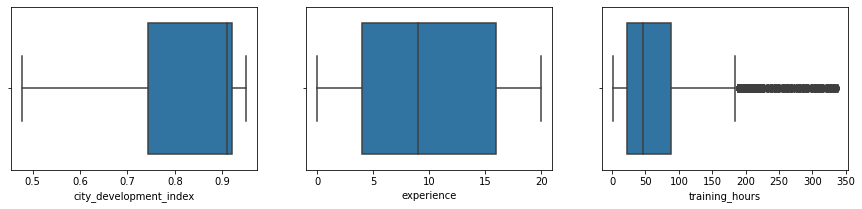

In [40]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot the first distplot on the first axes
sns.boxplot(x = new_df['city_development_index'],ax = ax[0])
sns.boxplot(x = new_df['experience'],ax = ax[1])
sns.boxplot(x = new_df['training_hours'],ax = ax[2])

# Show the plot
plt.show()

In [39]:
# Now let's see total number of outliers in city_development index
q1 = new_df['city_development_index'].quantile(0.25)
q3 = new_df['city_development_index'].quantile(0.75)

IQR = q3-q1
Lower_lmt_cdi = q1-(1.5*IQR)
Upper_lmt_cdi = q3 + (1.5*IQR)

new_df['city_development_index'] = np.where(
    new_df['city_development_index'] > Upper_lmt,
    Upper_lmt,
    np.where(
        new_df['city_development_index'] < Lower_lmt,
        Lower_lmt,
        new_df['city_development_index']
    )
)

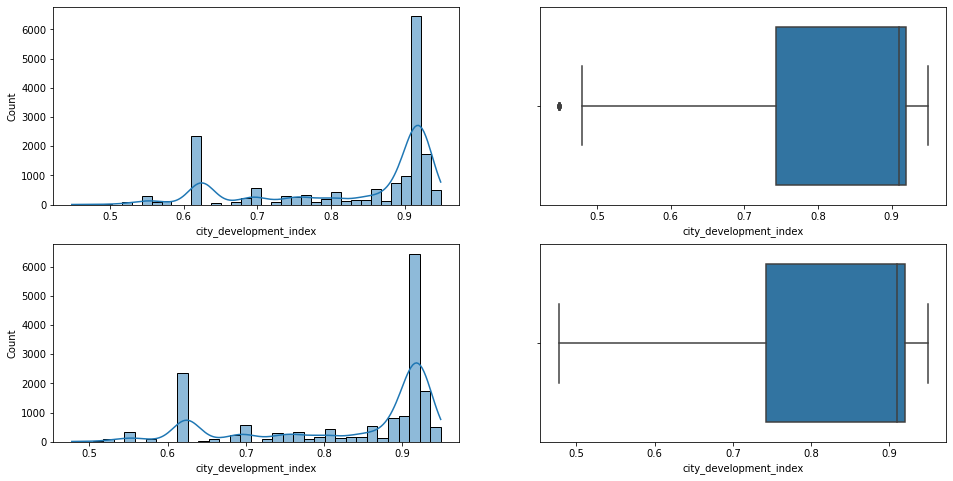

In [42]:
# Let's compare the distribution before and after capping the outliers 
plt.figure(figsize=(16,8))

# Before capping
plt.subplot(2,2,1)
sns.histplot(df['city_development_index'],kde=True)
plt.subplot(2,2,2)
sns.boxplot(x = df['city_development_index'])

# After capping
plt.subplot(2,2,3)
sns.histplot(new_df['city_development_index'],kde=True)
plt.subplot(2,2,4)
sns.boxplot(x = new_df['city_development_index'])

plt.show()

In [55]:
# Now let's see cap outliers in the training hours feature
q1 = new_df['training_hours'].quantile(0.25)
q3 = new_df['training_hours'].quantile(0.75)

IQR = q3-q1
Lower_lmt_th = q1-(1.5*IQR)
Upper_lmt_th = q3 + (1.5*IQR)

new_df['training_hours'] = np.where(
    new_df['training_hours'] > Upper_lmt,
    Upper_lmt,
    np.where(
        new_df['training_hours'] < Lower_lmt,
        Lower_lmt,
        new_df['training_hours']
    )
)

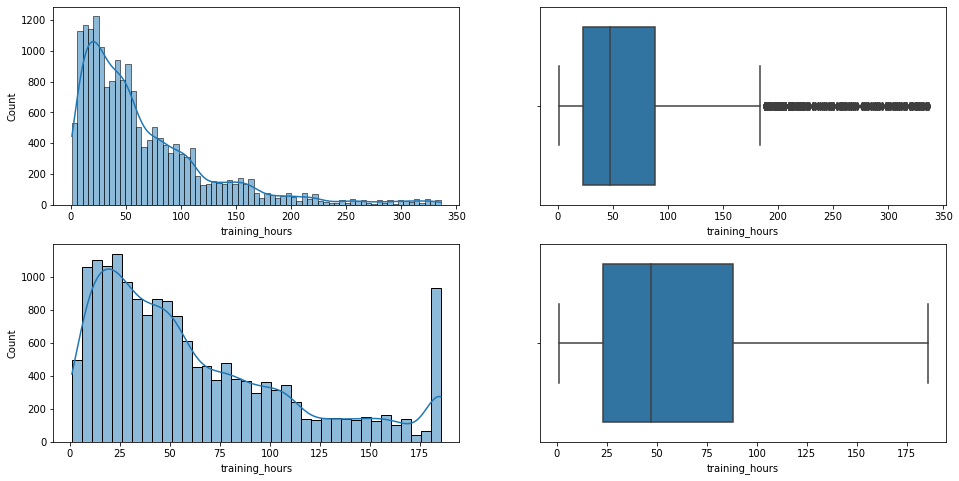

In [95]:
# Let's compare the distribution before and after capping the outliers 
plt.figure(figsize=(16,8))

# Before capping
plt.subplot(2,2,1)
sns.histplot(df['training_hours'],kde=True)
plt.subplot(2,2,2)
sns.boxplot(x = df['training_hours'])

# After capping
plt.subplot(2,2,3)
sns.histplot(new_df['training_hours'],kde=True)
plt.subplot(2,2,4)
sns.boxplot(x = new_df['training_hours'])

plt.show()

In [66]:
# Now some visualization or analysis purpose let us convert the encoded categorical data to categories
map_re = {1.0:'Has relevent experience',0.0:'No relevent experience'}
new_df['relevent_experience'] = new_df['relevent_experience'].map(map_re)

In [70]:
map_eu = {2.0:'Full time course' ,1.0:'Part time course', 0.0:'no_enrollment'}
new_df['enrolled_university'] = new_df['enrolled_university'].map(map_eu)

In [72]:
map_el = {0.0:'Primary School',1.1: 'High School', 2.0:'Graduate',3.0:'Masters',4.0:'Phd'}
new_df['education_level'] = new_df['education_level'].map(map_el)

In [80]:
new_df['company_size'] = new_df['company_size'].astype(np.int32)
map_cs = {0:'<10',1:'10/49',2:'50-99',3:'100-500',4:'500-999',5:'1000-4999',6:'5000-9999',7:'10000+'}
new_df['company_size'] = new_df['company_size'].map(map_cs)

In [82]:
new_df.head(4)

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,training_hours,Output
0,0.920,Has relevent experience,no_enrollment,Graduate,20.0,100-500,36.0,1.0
1,0.776,No relevent experience,no_enrollment,Graduate,15.0,50-99,47.0,0.0
2,0.624,No relevent experience,Full time course,Graduate,5.0,100-500,83.0,0.0
3,0.767,Has relevent experience,no_enrollment,Masters,20.0,50-99,8.0,0.0


<AxesSubplot:xlabel='company_size', ylabel='Output'>

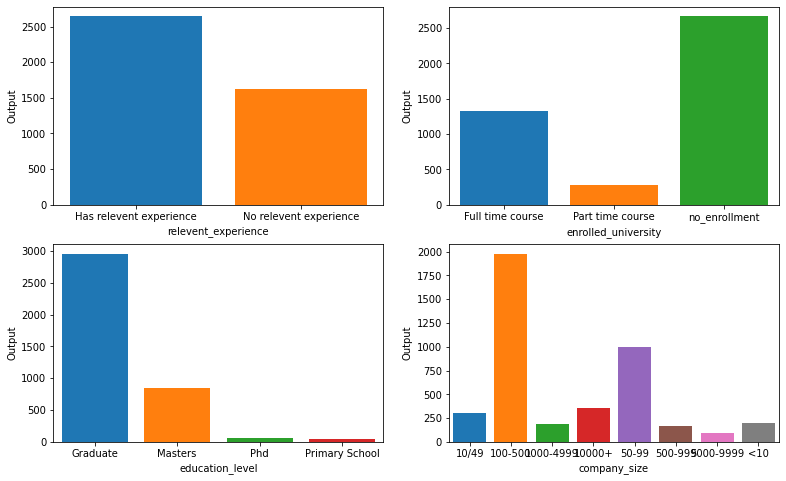

In [99]:
fig, ax = plt.subplots(2, 2, figsize=(13, 8))

check1 = new_df.groupby('relevent_experience')['Output'].sum()
sns.barplot(x = check1.index ,y =check1,saturation=1,ax = ax[0][0])

check2 = new_df.groupby('enrolled_university')['Output'].sum()
sns.barplot(x = check2.index ,y =check2,saturation=1,ax = ax[0][1])

check3 = new_df.groupby('education_level')['Output'].sum()
sns.barplot(x = check3.index ,y =check3,saturation=1,ax = ax[1][0])

check4 = new_df.groupby('company_size')['Output'].sum()
sns.barplot(x = check4.index ,y =check4,saturation=1,ax = ax[1][1])

1. Does better city_development_index means more people get job?
2. Does more education level leads to more jobs?

In [ ]:
plt.scatter(x = df['Output'])

# Feature engineering

In [39]:
new_df.head(5)

,city_dev_index,experience,training_hours,target,uni_enroll_ft,uni_enroll_pt,uni_enroll_n,major_discipline_arts,major_discipline_busn,major_discipline_hum,major_discipline_no,major_discipline_ot,major_discipline_stem,Relev_exp,Education_level,Company_size
0,0.920,20.0,74.0,1.0,0,0,1,0,0,0,0,0,1,1,4,1
1,0.920,10.0,126.0,0.0,0,0,1,0,0,0,0,0,1,1,2,0
2,0.926,20.0,114.0,0.0,0,0,1,0,0,0,0,0,1,1,3,1
3,0.527,4.0,36.0,0.0,0,0,1,0,0,0,0,0,1,1,2,0
4,0.920,4.0,58.0,1.0,0,0,1,0,0,0,0,0,1,1,2,0


<AxesSubplot:>

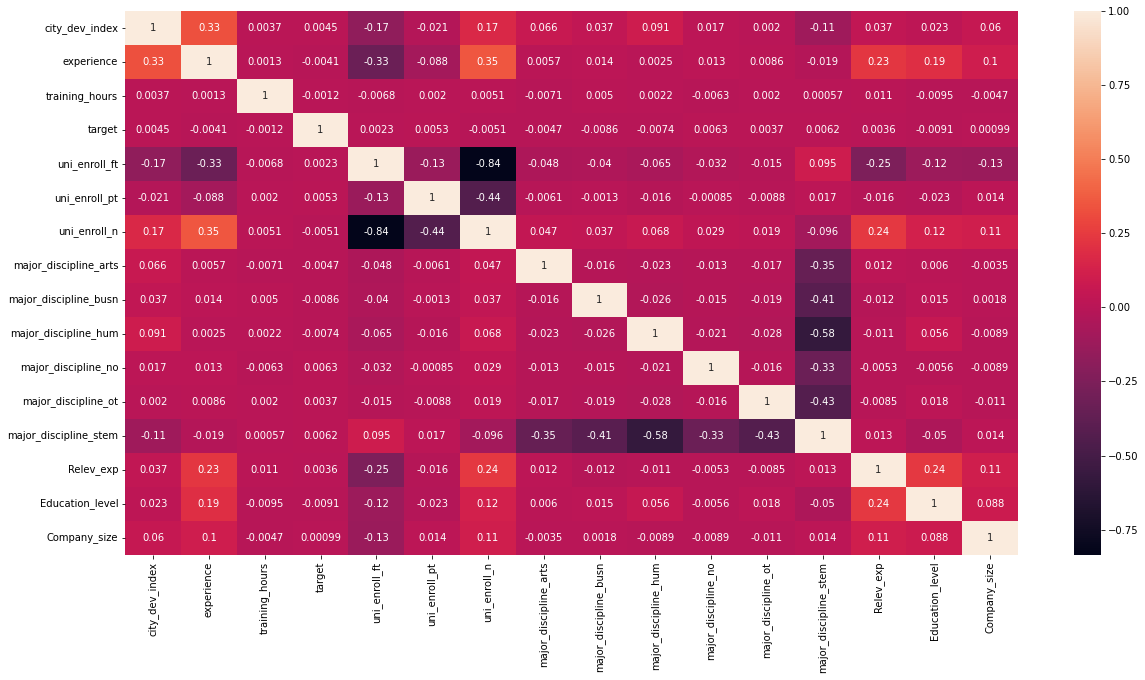

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(new_df.corr(),annot=True,ax = ax)

In [41]:
# We will create a new column 'enrolled_in_uni' where 0 will represent no and 1 will represent yes
new_df['enrolled_in_uni'] = 1-new_df['uni_enroll_n']
new_df = new_df.drop(['uni_enroll_ft', 'uni_enroll_pt', 'uni_enroll_n'],axis=1)

In [42]:
'''Will only keep the 'major_discipline_stem', where 1 will represent the person is from 
   Science/technology/engineering/mathematics filed and 0 will represent the person is not'''

new_df = new_df.drop(['major_discipline_arts', 'major_discipline_busn',
       'major_discipline_hum', 'major_discipline_no', 'major_discipline_ot'],axis=1)

In [43]:
new_df.head(4)

,city_dev_index,experience,training_hours,target,major_discipline_stem,Relev_exp,Education_level,Company_size,enrolled_in_uni
0,0.920,20.0,74.0,1.0,1,1,4,1,0
1,0.920,10.0,126.0,0.0,1,1,2,0,0
2,0.926,20.0,114.0,0.0,1,1,3,1,0
3,0.527,4.0,36.0,0.0,1,1,2,0,0


In [44]:
new_df.shape

(17182, 9)

<AxesSubplot:>

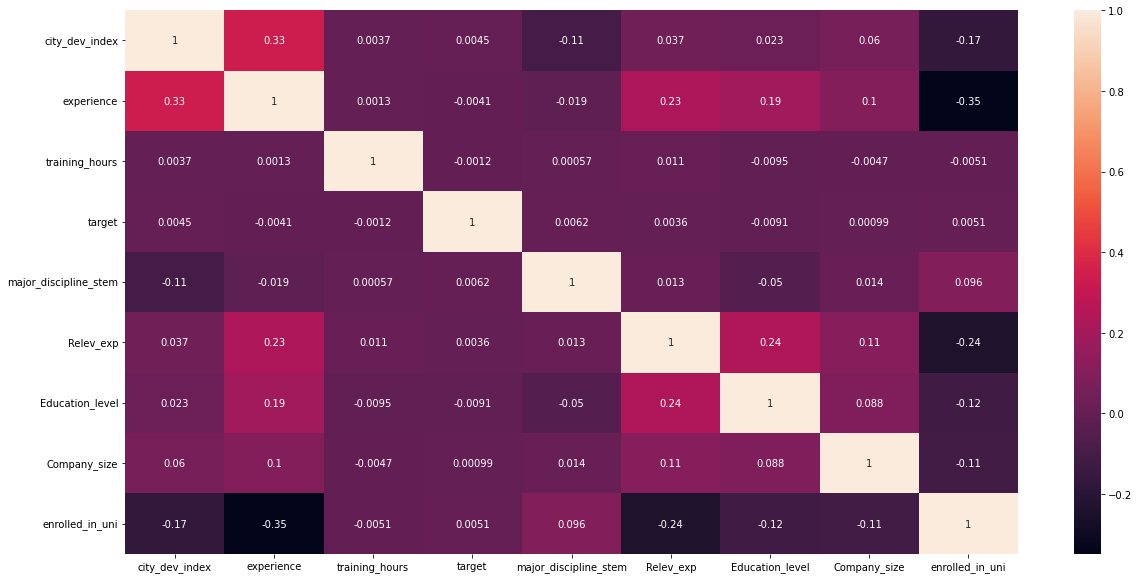

In [45]:
# After data preprocessing and feature engineering
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(new_df.corr(),annot=True,ax = ax)

<AxesSubplot:>

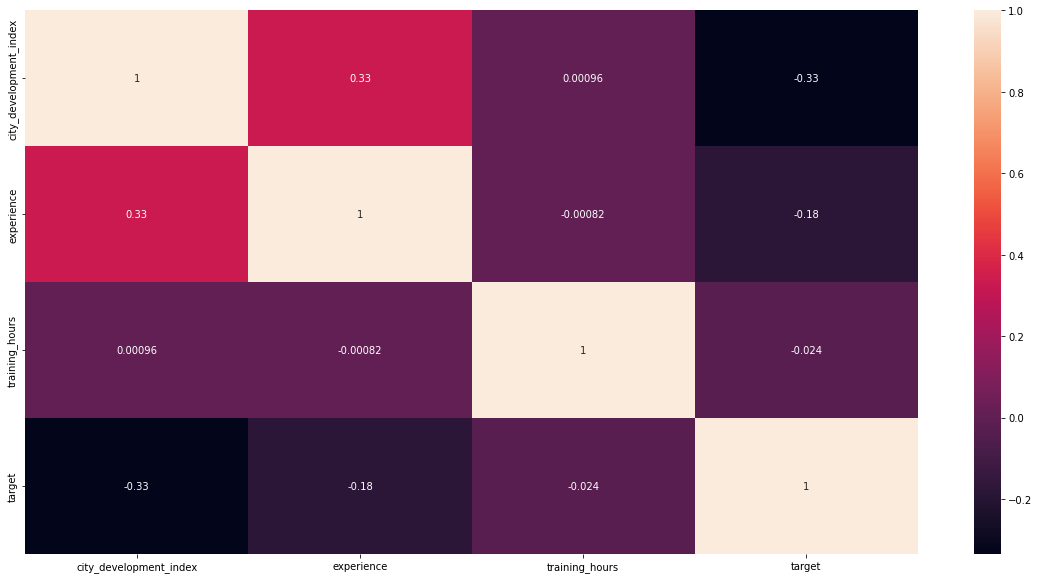

In [46]:
# Raw dataframe
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df.corr(),annot=True,ax = ax)